# demo_lenspyx

This notebook shows how to generate lensed CMB maps with DUCC-based lenspyx on pixelized skies ([this paper](https://arxiv.org/abs/2304.10431)).

The map constructions in this notebook should take $\mathcal O$(seconds) on a modern laptop.

For other stuff lenspyx.tests might contain other useful scripts or you can contact me

In [1]:
%matplotlib inline
import os
import pylab as pl
import numpy as np
import lenspyx

In [2]:
# We first generate an unlensed temperature and lensing potential. 
# Here for simplicity we use synalm, neglecting correlations between T, E and phi.

from lenspyx.utils import camb_clfile
from lenspyx.utils_hp import synalm, almxfl, alm2cl

lmax_len = 3000 # desired lmax of the lensed field.
dlmax = 1024  # lmax of the unlensed fields is lmax + dlmax.  (some buffer is required for accurate lensing at lmax)
epsilon = 1e-6 # target accuracy of the output maps (execution time has a fairly weak dependence on this)
lmax_unl, mmax_unl = lmax_len + dlmax, lmax_len + dlmax

cls_path = os.path.join(os.path.dirname(os.path.abspath(lenspyx.__file__)), 'data', 'cls')

cl_len = camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lensedCls.dat'))
cl_unl = camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lenspotentialCls.dat'))

tlm_unl = synalm(cl_unl['tt'], lmax=lmax_unl, mmax=mmax_unl)
elm_unl = synalm(cl_unl['ee'], lmax=lmax_unl, mmax=mmax_unl)
blm_unl = synalm(cl_unl['bb'], lmax=lmax_unl, mmax=mmax_unl)

plm = synalm(cl_unl['pp'], lmax=lmax_unl, mmax=mmax_unl)

# We then transform the lensing potential into spin-1 deflection field, and deflect the temperature map.
dlm = almxfl(plm, np.sqrt(np.arange(lmax_unl + 1, dtype=float) * np.arange(1, lmax_unl + 2)), None, False)

In [3]:
# Geometry on which to produce the lensed map
geom_info = ('healpix', {'nside':2048}) # here we will use an Healpix grid with nside 2048

# Unlensed T map is this:
geom = lenspyx.get_geom(geom_info)
Tunl = geom.alm2map(tlm_unl, lmax_unl, mmax_unl, nthreads=os.cpu_count())

alm2lenmap: using 8 nthreads
  build angles <- synthesis (GRAD_ONLY):  [0:00:09.240753] (38.7%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.931065] (3.9%)  
  build_angles                         :  [0:00:10.171855] (42.6%)  
  synthesis general (STANDARD)         :  [0:00:13.306240] (55.7%)  
  gclm2lenmap                          :  [0:00:23.589017] (98.7%)  
  polrot (ducc)                        :  [0:00:00.110627] (0.5%)  
  Total                                :  [0:00:23.889884] d:h:m:s:mus


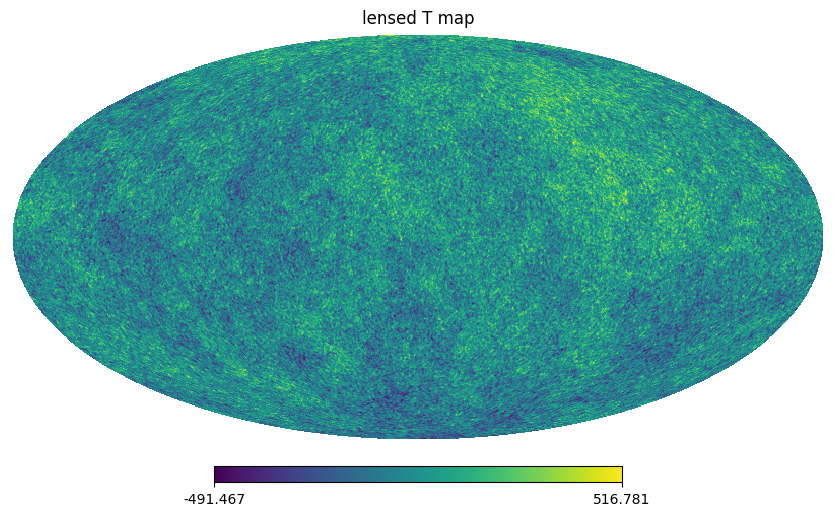

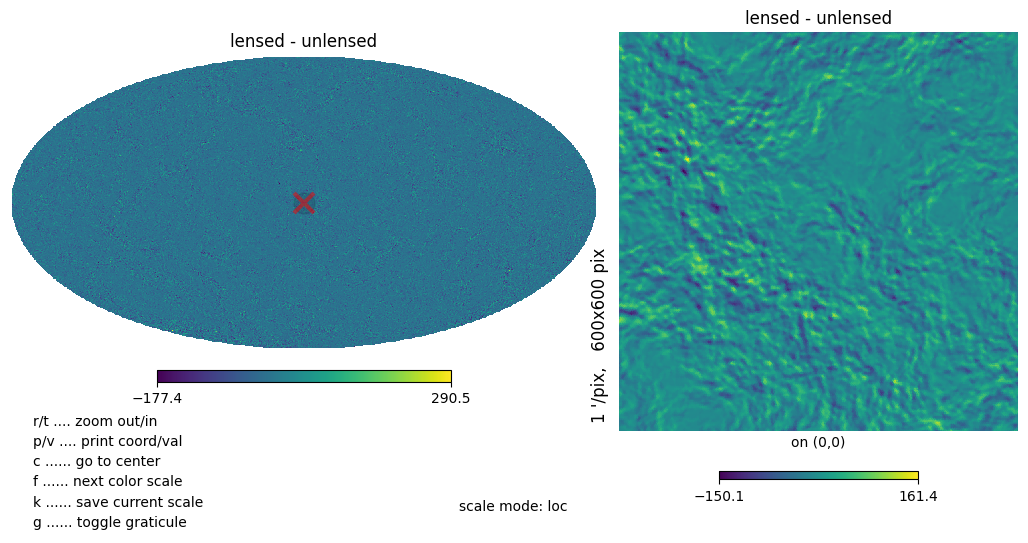

In [4]:
# Lensed T and Pol. maps:
Tlen, Qlen, Ulen = lenspyx.alm2lenmap([tlm_unl, elm_unl, blm_unl], dlm, geometry=geom_info, verbose=1, epsilon=epsilon)

import healpy as hp
hp.mollview(Tlen, title='lensed T map')
hp.mollzoom(Tlen -Tunl, title='lensed - unlensed')

In [5]:
# The unlensed B-mode was zero, we could have used this just as well, with in principle slightly faster results in the polarisation step
Tlen, Qlen, Ulen = lenspyx.alm2lenmap([tlm_unl, elm_unl], dlm, geometry=geom_info, verbose=1)

alm2lenmap: using 8 nthreads
  build angles <- synthesis (GRAD_ONLY):  [0:00:10.111033] (38.4%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.960274] (3.7%)  
  build_angles                         :  [0:00:11.071326] (42.1%)  
  synthesis general (STANDARD)         :  [0:00:05.296787] (20.1%)  
  gclm2lenmap                          :  [0:00:26.216761] (99.7%)  
  synthesis general (GRAD_ONLY)        :  [0:00:09.721431] (37.0%)  
  polrot (ducc)                        :  [0:00:00.127078] (0.5%)  
  Total                                :  [0:00:26.298404] d:h:m:s:mus


In [6]:
# T-P independent constructions (redundant angle construction work for T and P)
Tlen = lenspyx.alm2lenmap(tlm_unl, dlm, geometry=geom_info, verbose=1)
Qlen, Ulen = lenspyx.alm2lenmap_spin(elm_unl, dlm, 2, geometry=geom_info, verbose=1)

alm2lenmap: using 8 nthreads
  build angles <- synthesis (GRAD_ONLY):  [0:00:10.042143] (70.6%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.749014] (5.3%)  
  build_angles                         :  [0:00:10.791175] (75.9%)  
  synthesis general (STANDARD)         :  [0:00:03.429824] (24.1%)  
  gclm2lenmap                          :  [0:00:14.221149] (100.0%)  
  Total                                :  [0:00:14.221251] d:h:m:s:mus
alm2lenmap_spin: using 8 nthreads
  build angles <- synthesis (GRAD_ONLY):  [0:00:10.623528] (55.6%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.745172] (3.9%)  
  build_angles                         :  [0:00:11.368725] (59.5%)  
  synthesis general (GRAD_ONLY)        :  [0:00:07.625575] (39.9%)  
  polrot (ducc)                        :  [0:00:00.112509] (0.6%)  
  gclm2lenmap                          :  [0:00:19.106891] (100.0%)  
  Total                                :  [0:00:19.106975] d:h:m:s:mus


alm2lenmap: using 8 nthreads
  build angles <- synthesis (STANDARD):  [0:00:13.533559] (76.5%)  
  build angles <- th-phi-gm (ducc)    :  [0:00:00.734823] (4.2%)  
  build_angles                        :  [0:00:14.268442] (80.7%)  
  synthesis general (STANDARD)        :  [0:00:03.413968] (19.3%)  
  gclm2lenmap                         :  [0:00:17.682401] (100.0%)  
  Total                               :  [0:00:17.682477] d:h:m:s:mus


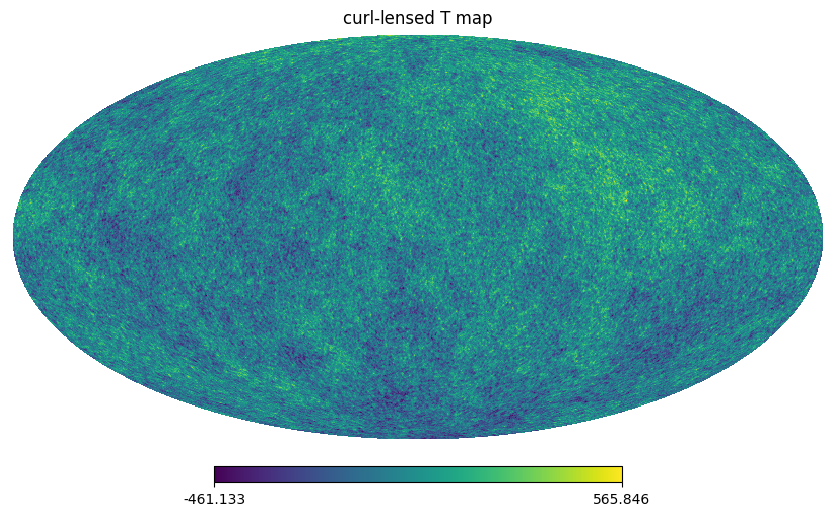

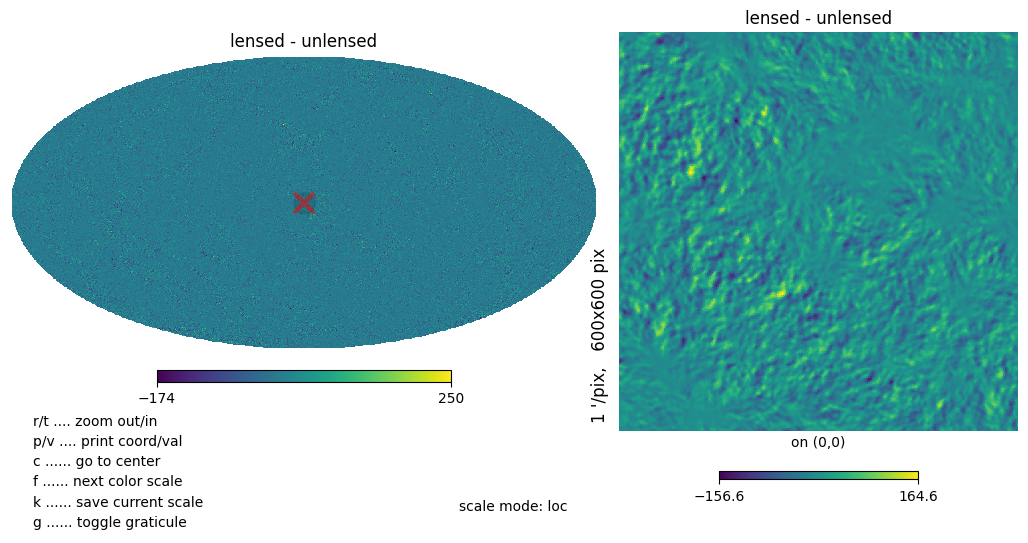

In [7]:
# To add a curl deflection, can just do this: (here taking curl equal to phi for fun)
clm = dlm.copy() # here taking curl equal to phi and setting gradient to zero just for fun
Tlen = lenspyx.alm2lenmap(tlm_unl, [dlm * 0., clm], geometry=geom_info, verbose=1)
hp.mollview(Tlen, title='curl-lensed T map')
hp.mollzoom(Tlen -Tunl, title='lensed - unlensed')

In [8]:
# Other geometries: thinned Gauss-Legendre is often a good choice since in contrast to healpix it gives good quadrature with economy of rings:
gl_geom_info = ('thingauss', {'smax': 2, 'lmax':lmax_unl})  # increase lmax here to get more accurate quadrature
Tlen, Qlen, Ulen  = lenspyx.alm2lenmap([tlm_unl, elm_unl], dlm, geometry=gl_geom_info, verbose=1)

alm2lenmap: using 8 nthreads
  build angles <- synthesis (GRAD_ONLY):  [0:00:04.427472] (30.7%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.299983] (2.1%)  
  build_angles                         :  [0:00:04.727475] (32.8%)  
  synthesis general (STANDARD)         :  [0:00:02.603745] (18.1%)  
  gclm2lenmap                          :  [0:00:14.327761] (99.5%)  
  synthesis general (GRAD_ONLY)        :  [0:00:06.947858] (48.2%)  
  polrot (ducc)                        :  [0:00:00.048626] (0.3%)  
  Total                                :  [0:00:14.405667] d:h:m:s:mus


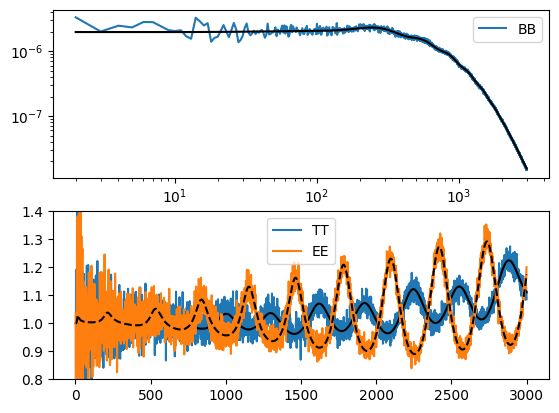

In [9]:
# Let's go back to Fourier space and build spectra
gl_geom = lenspyx.get_geom(gl_geom_info)
elm_len, blm_len = gl_geom.map2alm_spin([Qlen, Ulen], 2, lmax_len, lmax_len, nthreads=os.cpu_count())
tlm_len = gl_geom.map2alm(Tlen, lmax_len, lmax_len, nthreads=os.cpu_count()) # (Be aware that geom.map2alm will in general modify the input map, multplying it by the quadrature weights)

# plots against pred
fig,axes = pl.subplots(2, 1)
clbb_len = alm2cl(blm_len, blm_len, lmax_len, lmax_len, lmax_len) # Same as hp.alm2cl
ls = np.arange(2, lmax_len + 1)
pl.sca(axes[0])
pl.loglog(ls, clbb_len[ls], label='BB')
pl.plot(ls, cl_len['bb'][ls], c='k')
pl.legend()
pl.sca(axes[1])
cltt_len = alm2cl(tlm_len, tlm_len, lmax_len, lmax_len, lmax_len)
clee_len = alm2cl(elm_len, elm_len, lmax_len, lmax_len, lmax_len)
pl.plot(ls, cltt_len[ls]/ cl_unl['tt'][ls], label='TT')
pl.plot(ls, cl_len['tt'][ls]/ cl_unl['tt'][ls], c='k')
pl.plot(ls, clee_len[ls]/ cl_unl['ee'][ls], label='EE')
pl.plot(ls, cl_len['ee'][ls]/ cl_unl['ee'][ls], c='k', ls='--')
pl.ylim(0.8, 1.4)
pl.legend()

In [10]:
# Available geometries, custom geoms can easily be added, check code there
from lenspyx.remapping.utils_geom import Geom
Geom.show_supported_geometries()

supported geometries: 
thingauss:
Longitude-thinned Gauss-Legendre pixelization

            Args:
                lmax: number of latitude points is lmax + 1 (exact quadrature rules for this band-limit)
                smax: maximum spin-weight to be used on this grid (impact slightly the choice of longitude points)
                good_size_real(optional): decides on a FFT-friendly number of phi point for real if set or complex FFTs'
                                          (very slightly more points if set but largely inconsequential)


        
healpix:
Healpix pixelization

            Args:
                nside: healpix nside resolution parameter (npix is 12 * nside ** 2)


        
cc:
Clenshaw-Curtis pixelization

            Uniformly-spaced in latitude, one point on each pole

            Args:
                ntheta: number of latitude points
                nphi: number of longitude points


        
f1:
Fejer-1 pixelization

            Uniformly-spaced in latitude, firs